In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import custom_funcs as cf
import pandas as pd
import numpy as np

In [2]:
drugs = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV',]
drug = drugs[1]
protein = 'protease'

data, feat_cols = cf.get_cleaned_data(protein, drug)

# Just checking:
cf.test_data_integrity(data)

## Now, let's do data transformations.
data_mw = cf.to_numeric_rep(data, feat_cols, rep='mw')
data_pKa = cf.to_numeric_rep(data, feat_cols, rep='pKa')

# Split the MW data into a training set, and test set.
X_mw, Y_mw, X_train_mw, X_test_mw, Y_train_mw, Y_test_mw = cf.to_train_test_split(data_mw, feat_cols, drug, test_size=0.3)

# Convert all of the datapoints to numpy arrays.
X_mw = cf.pd2np(X_mw)
Y_mw = cf.pd2np(Y_mw)
X_train_mw = cf.pd2np(X_train_mw)
X_test_mw = cf.pd2np(X_test_mw)
Y_train_mw = cf.pd2np(Y_train_mw)
Y_test_mw = cf.pd2np(Y_test_mw)


# Do likewise for pKa data
X_pKa, Y_pKa, X_train_pKa, X_test_pKa, Y_train_pKa, Y_test_pKa = cf.to_train_test_split(data_pKa, feat_cols, drug, test_size=0.3)

# Convert all of the datapoints to numpy arrays.
X_pKa = cf.pd2np(X_pKa)
Y_pKa = cf.pd2np(Y_pKa)
X_train_pKa = cf.pd2np(X_train_pKa)
X_test_pKa = cf.pd2np(X_test_pKa)
Y_train_pKa = cf.pd2np(Y_train_pKa)
Y_test_pKa = cf.pd2np(Y_test_pKa)

In [3]:
n_datapoints = len(X_mw)
n_datapoints

464

In [4]:
# Reshape the Y-data so that they have a 2-tuple of shapes.
Y_mw = Y_mw.reshape(Y_mw.shape[0], -1)
Y_train_mw = Y_train_mw.reshape(Y_train_mw.shape[0], -1)
Y_test_mw = Y_test_mw.reshape(Y_test_mw.shape[0], -1)

Y_pKa = Y_pKa.reshape(Y_pKa.shape[0], -1)
Y_train_pKa = Y_train_pKa.reshape(Y_train_pKa.shape[0], -1)
Y_test_pKa = Y_test_pKa.reshape(Y_test_pKa.shape[0], -1)

In [5]:
X_mw.shape

(464, 99)

In [6]:
Y_pKa.shape

(464, 1)

In [7]:
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_regression
from theano.tensor.nnet import relu

In [8]:
# These are linear model specifications.
# DO NOT DELETE!!!!

input_mw = theano.shared(X_train_mw)
input_pKa = theano.shared(X_train_pKa)
output = theano.shared(Y_train_pKa)  

with pm.Model() as linreg_mw:
    linweights_mw = pm.Normal('linweights', mu=0, sd=1, shape=(X_mw.shape[1], Y_mw.shape[1]))
    linbiases_mw = pm.Normal('linbiases', mu=0, sd=1, shape=(Y_mw.shape[1]))
    
    output_mw = pm.Normal('Y', T.dot(input_mw, linweights_mw) + linbiases_mw, observed=output)
    
    
with pm.Model() as linreg_pKa:
    linweights_pKa = pm.Normal('linweights', mu=0, sd=1, shape=(X_pKa.shape[1], Y_pKa.shape[1]))
    linbiases_pKa = pm.Normal('linbiases', mu=0, sd=1, shape=(Y_pKa.shape[1]))
    
    output_pKa = pm.Normal('Y', T.dot(input_pKa, linweights_pKa) + linbiases_pKa, observed=output)



In [9]:
with pm.Model() as mixlinear:
    l1_pKa_weights = pm.Normal('l1_pKa_weights', mu=0, sd=1, shape=(X_mw.shape[1], Y_mw.shape[1]))
    # l1_pKa_biases = pm.Normal('l1_pKa_biases', mu=0, sd=1, shape=(X.shape[1]))
    l1_mw_weights = pm.Normal('l1_mw_weights', mu=0, sd=1, shape=(X_pKa.shape[1], Y_pKa.shape[1]))
    
    l1_pKa_out = T.dot(input_pKa, l1_pKa_weights)
    l1_mw_out = T.dot(input_mw, l1_mw_weights)
    
    l2_input = T.sum([l1_pKa_out, l1_mw_out], axis=0)
    
    l2_weights = pm.Normal('l2_weights', mu=0, sd=1, shape=(1, Y_mw.shape[1]))
    
    pred_spec = T.dot(l2_input, l2_weights)
    
    preds = pm.Normal('Y', pred_spec, observed=output)

In [11]:
%%time
# This is the linear pKa model posterior fitter.
with linreg_pKa:
    v_params_pKa = pm.variational.advi(n=400000)

with linreg_mw:
    v_params_mw = pm.variational.advi(n=400000)

# # This is the mixlinear model posterior fitter.
# with mixlinear:
#     # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
#     v_params_mixlin = pm.variational.advi(n=150000)

Iteration 0 [0%]: ELBO = -62181.75
Iteration 40000 [10%]: Average ELBO = -252741.06
Iteration 80000 [20%]: Average ELBO = -24101.36
Iteration 120000 [30%]: Average ELBO = -3016.55
Iteration 160000 [40%]: Average ELBO = -1010.97
Iteration 200000 [50%]: Average ELBO = -847.84
Iteration 240000 [60%]: Average ELBO = -832.75
Iteration 280000 [70%]: Average ELBO = -828.95
Iteration 320000 [80%]: Average ELBO = -825.01
Iteration 360000 [90%]: Average ELBO = -823.98
Finished [100%]: Average ELBO = -821.64
Iteration 0 [0%]: ELBO = -4327434.82
Iteration 40000 [10%]: Average ELBO = -100992953.37
Iteration 80000 [20%]: Average ELBO = -9604408.71
Iteration 120000 [30%]: Average ELBO = -960238.97
Iteration 160000 [40%]: Average ELBO = -102304.19
Iteration 200000 [50%]: Average ELBO = -14702.12
Iteration 240000 [60%]: Average ELBO = -4004.69
Iteration 280000 [70%]: Average ELBO = -2412.46
Iteration 320000 [80%]: Average ELBO = -2109.02
Iteration 360000 [90%]: Average ELBO = -2050.2
Finished [100%]: A

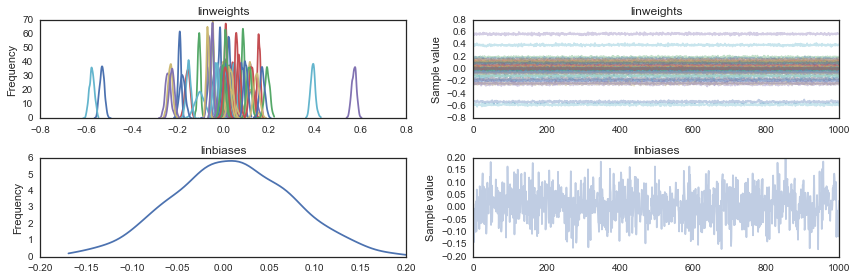

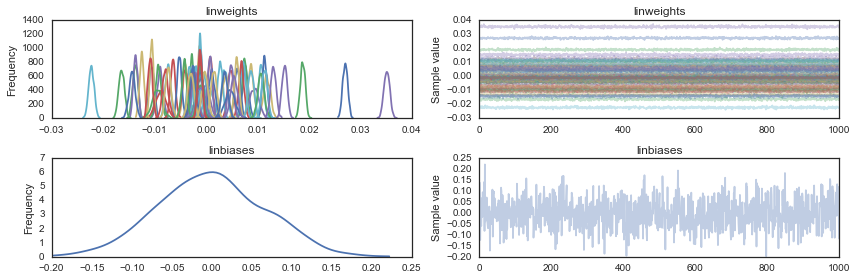

In [13]:
%matplotlib inline
with linreg_pKa:
    trace_pKa = pm.variational.sample_vp(v_params_pKa, draws=1000)
    pm.traceplot(trace_pKa)
    
with linreg_mw:
    trace_mw = pm.variational.sample_vp(v_params_mw, draws=1000)
    pm.traceplot(trace_mw)

<Container object of 3 artists>

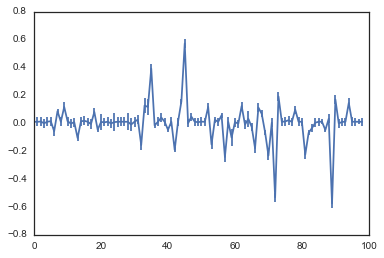

In [30]:
# plt.plot(trace_mw.linweights_mw.mean(axis=0))
plt.errorbar(range(99), trace_pKa.linweights.mean(axis=0), yerr=trace_pKa.linweights.std(axis=0)*3)
# plt.bar(range(99), trace_pKa.linweights.mean(axis=0))

In [31]:
input_pKa.set_value(X_test_pKa)
input_mw.set_value(X_test_mw)
# output.set_value(Y_test_pKa)

ppc_pKa = pm.sample_ppc(trace_pKa, model=linreg_pKa, samples=10)
ppc_mw = pm.sample_ppc(trace_mw, model=linreg_mw, samples=10)

In [32]:
mdl_avg_preds = (ppc_pKa['Y'] + ppc_mw['Y'] )/2

<Container object of 3 artists>

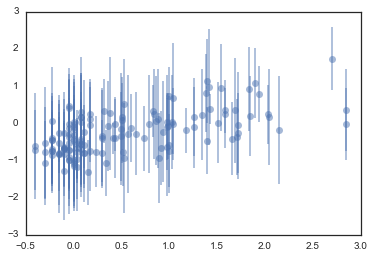

In [33]:
ycol = 0
ys = Y_test_pKa[:, ycol]
preds = ppc_pKa['Y'].mean(axis=0)[:, ycol]
yerr = ppc_pKa['Y'].std(axis=0)[:, ycol]
plt.errorbar(ys, preds, yerr=yerr, ls='none', marker='o', alpha=0.5)
# plt.ylim(-5, 5)
# plt.scatter(ys, preds)

# ys = Y_test_pKa[:, 0]
# preds = mdl_avg_preds.mean(axis=0)[:, 0]
# yerr = mdl_avg_preds.std(axis=0)[:, 0]
# preds.shape, yerr.shape
# plt.errorbar(ys, preds, yerr=yerr, marker='o', ls='none')

Let's get a ranked list of the weights. This will return us the most influential set of weights, corresponding to the positions that are most predictive of drug resistance value. The top-ranked are positively-correlated with drug resistance, and the bottom-ranked are negatively-correlated, based on molecular weight value at that position.

In [23]:
trace_mw.varnames

['linweights', 'linbiases']

In [25]:
trace_pKa['linweights'].mean(axis=0)

array([[  1.02711969e-02],
       [  9.82959399e-03],
       [  1.21085465e-02],
       [ -5.89870605e-04],
       [  1.09717104e-02],
       [  1.40257244e-02],
       [ -5.79130691e-02],
       [  8.63345924e-02],
       [  9.96798694e-03],
       [  1.16614134e-01],
       [  1.43921613e-02],
       [ -2.58814699e-03],
       [  7.53087785e-03],
       [ -1.06217619e-01],
       [  1.35220130e-02],
       [  1.75246344e-02],
       [  1.02136161e-02],
       [ -5.97446900e-03],
       [  8.07598338e-02],
       [ -4.67901631e-02],
       [  9.13749290e-03],
       [  6.32324907e-03],
       [  1.03705177e-02],
       [ -1.20848893e-03],
       [  7.89270171e-03],
       [  1.01843617e-02],
       [  1.05095618e-02],
       [  1.02331131e-02],
       [  1.01497501e-02],
       [ -9.60512773e-03],
       [  1.07587873e-02],
       [  2.56422047e-02],
       [ -1.56767054e-01],
       [  1.27040389e-01],
       [  1.16129500e-01],
       [  3.91760113e-01],
       [ -1.57132272e-02],
 

In [ ]:
positions = trace_mw['linweights_mw'].mean(axis=0).reshape(X_test_mw.shape[1]).argsort() + 1
positions[0:10], positions[-10:]

Let's load the HIVDB set of weights.

In [ ]:
from IPython.display import HTML

In [ ]:
HTML('http://hivdb.stanford.edu/DR/PIResiNote.html')